<a href="https://colab.research.google.com/github/aniqaizuddin/Bugging-BadBad/blob/main/Bugging_Badbad_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cybotrade-datasource
import pandas as pd
import asyncio
from datetime import datetime, timezone
import cybotrade_datasource

API_KEY = "7FzTcgRWspHPdrSwl8N8yeW1jBbpCgp2isjiwFj4Hy0fpSgo"

async def fetch_data_from_endpoint(topic, start_time, end_time):
    """
    Fetch data from a given endpoint and return as a DataFrame.
    """
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY,
        topic=topic,
        start_time=start_time,
        end_time=end_time
    )

    # Convert the fetched data into a DataFrame
    df = pd.DataFrame(data)

        # Drop the original 'datetime' column if it exists
    if 'datetime' in df.columns:
        df = df.drop(columns=['datetime'])

    return df

async def fetch_all_data():
    """
    Fetch data from multiple endpoints efficiently and merge the results.
    """
    # Define the list of topics (endpoints) to fetch data from
    topics = [
        'cryptoquant|btc/exchange-flows/netflow?exchange=binance&window=hour',
        'cryptoquant|btc/market-data/price-ohlcv?window=hour&exchange=binance'
    ]

    # Set the time range for the query
    start_time = datetime(2020, 1, 1, tzinfo=timezone.utc)
    end_time = datetime(2025, 1, 1, tzinfo=timezone.utc)

    data_frames = await asyncio.gather(
        *[fetch_data_from_endpoint(topic, start_time, end_time) for topic in topics]
    )

    # Use asyncio.gather to fetch data from all endpoints concurrently
    data_frames = await asyncio.gather(
        *[fetch_data_from_endpoint(topic, start_time, end_time) for topic in topics]
    )

    # If needed, merge or further process the DataFrames here
    final_df = data_frames[0]  # Example of taking the first DataFrame
    for df in data_frames[1:]:
        final_df = pd.merge(final_df, df, on='start_time', how='outer')  # Adjust based on actual column names

    # Convert 'start_time' to human-readable datetime (UTC) and insert as a new column
    final_df['date_time'] = pd.to_datetime(final_df['start_time'], unit='ms', utc=True)

    # Optional: reorder columns to have 'datetime' first
    cols = ['date_time'] + [col for col in final_df.columns if col != 'date_time']
    final_df = final_df[cols]

    print(final_df.head())  # Display the first few rows of the merged DataFrame
    return final_df


# Running the fetch function
df = await fetch_all_data()

df

                  date_time     start_time  netflow_total    close     high  \
0 2020-01-01 00:00:00+00:00  1577836800000      22.868824  7177.02  7196.25   
1 2020-01-01 01:00:00+00:00  1577840400000      75.134734  7216.27  7230.00   
2 2020-01-01 02:00:00+00:00  1577844000000     -99.358706  7242.85  7244.87   
3 2020-01-01 03:00:00+00:00  1577847600000     -12.874796  7225.01  7245.00   
4 2020-01-01 04:00:00+00:00  1577851200000      -1.265298  7217.27  7230.00   

       low     open      volume  
0  7175.46  7195.24  511.814901  
1  7175.71  7176.47  883.052603  
2  7211.41  7215.52  655.156809  
3  7220.00  7242.66  783.724867  
4  7215.03  7225.00  467.812578  


,date_time,start_time,netflow_total,close,high,low,open,volume
0,2020-01-01 00:00:00+00:00,1577836800000,22.868824,7177.02,7196.25,7175.46,7195.24,511.814901
1,2020-01-01 01:00:00+00:00,1577840400000,75.134734,7216.27,7230.00,7175.71,7176.47,883.052603
2,2020-01-01 02:00:00+00:00,1577844000000,-99.358706,7242.85,7244.87,7211.41,7215.52,655.156809
3,2020-01-01 03:00:00+00:00,1577847600000,-12.874796,7225.01,7245.00,7220.00,7242.66,783.724867
4,2020-01-01 04:00:00+00:00,1577851200000,-1.265298,7217.27,7230.00,7215.03,7225.00,467.812578
...,...,...,...,...,...,...,...,...
43843,2024-12-31 19:00:00+00:00,1735671600000,-285.605408,94166.88,94290.91,93712.45,93875.69,462.793420
43844,2024-12-31 20:00:00+00:00,1735675200000,-105.886628,93564.04,94222.50,93450.17,94166.88,733.041470
43845,2024-12-31 21:00:00+00:00,1735678800000,-201.777895,93899.68,93964.15,93504.67,93564.01,337.527150
43846,2024-12-31 22:00:00+00:00,1735682400000,697.030595,93488.84,93899.67,93375.58,93899.67,315.532720


In [ ]:
netflow_series = df[['date_time', 'start_time', 'netflow_total']]
netflow_series['ema_168'] = netflow_series['netflow_total'].ewm(span=168, adjust=False).mean()
netflow_series

<ipython-input-110-7e60e98efbf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflow_series['ema_168'] = netflow_series['netflow_total'].ewm(span=168, adjust=False).mean()


,date_time,start_time,netflow_total,ema_168
0,2020-01-01 00:00:00+00:00,1577836800000,22.868824,22.868824
1,2020-01-01 01:00:00+00:00,1577840400000,75.134734,23.487355
2,2020-01-01 02:00:00+00:00,1577844000000,-99.358706,22.033556
3,2020-01-01 03:00:00+00:00,1577847600000,-12.874796,21.620439
4,2020-01-01 04:00:00+00:00,1577851200000,-1.265298,21.349602
...,...,...,...,...
43843,2024-12-31 19:00:00+00:00,1735671600000,-285.605408,9.327449
43844,2024-12-31 20:00:00+00:00,1735675200000,-105.886628,7.963968
43845,2024-12-31 21:00:00+00:00,1735678800000,-201.777895,5.481816
43846,2024-12-31 22:00:00+00:00,1735682400000,697.030595,13.665825


In [ ]:
close_series = df[['date_time', 'start_time', 'close']].dropna().reset_index(drop=True)
close_series['price_return'] = close_series['close'].diff()  # close_t - close_t-1
close_series['price_direction'] = close_series['price_return'].apply(lambda x: 1 if x > 0 else 0)
close_series.dropna(inplace=True)
close_series.reset_index(inplace=True)
close_series

,index,date_time,start_time,close,price_return,price_direction
0,1,2020-01-01 01:00:00+00:00,1577840400000,7216.27,39.25,1
1,2,2020-01-01 02:00:00+00:00,1577844000000,7242.85,26.58,1
2,3,2020-01-01 03:00:00+00:00,1577847600000,7225.01,-17.84,0
3,4,2020-01-01 04:00:00+00:00,1577851200000,7217.27,-7.74,0
4,5,2020-01-01 05:00:00+00:00,1577854800000,7224.21,6.94,1
...,...,...,...,...,...,...
43811,43812,2024-12-31 19:00:00+00:00,1735671600000,94166.88,291.20,1
43812,43813,2024-12-31 20:00:00+00:00,1735675200000,93564.04,-602.84,0
43813,43814,2024-12-31 21:00:00+00:00,1735678800000,93899.68,335.64,1
43814,43815,2024-12-31 22:00:00+00:00,1735682400000,93488.84,-410.84,0


In [ ]:
# 1. Imports
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# 2. Prepare merged dataset
close_series = close_series[['date_time', 'price_direction']].copy()
netflow_series = netflow_series[['date_time', 'ema_168']].copy()
hmm_df = pd.merge(close_series, netflow_series, on='date_time')
hmm_df.dropna(inplace=True)

# 3. Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(hmm_df[['price_direction', 'ema_168']])

# 4. Train Gaussian HMM
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=300, random_state=42)
model.fit(scaled_features)

# 5. Predict regimes
hmm_df['regime'] = model.predict(scaled_features)


In [ ]:
# Mapping based on interpretation
regime_map = {
    0: 'Bull',
    1: 'Bear',
    2: 'Sideways'
}

# Add a readable label column
hmm_df['regime_label'] = hmm_df['regime'].map(regime_map)


<IPython.core.display.Javascript object>

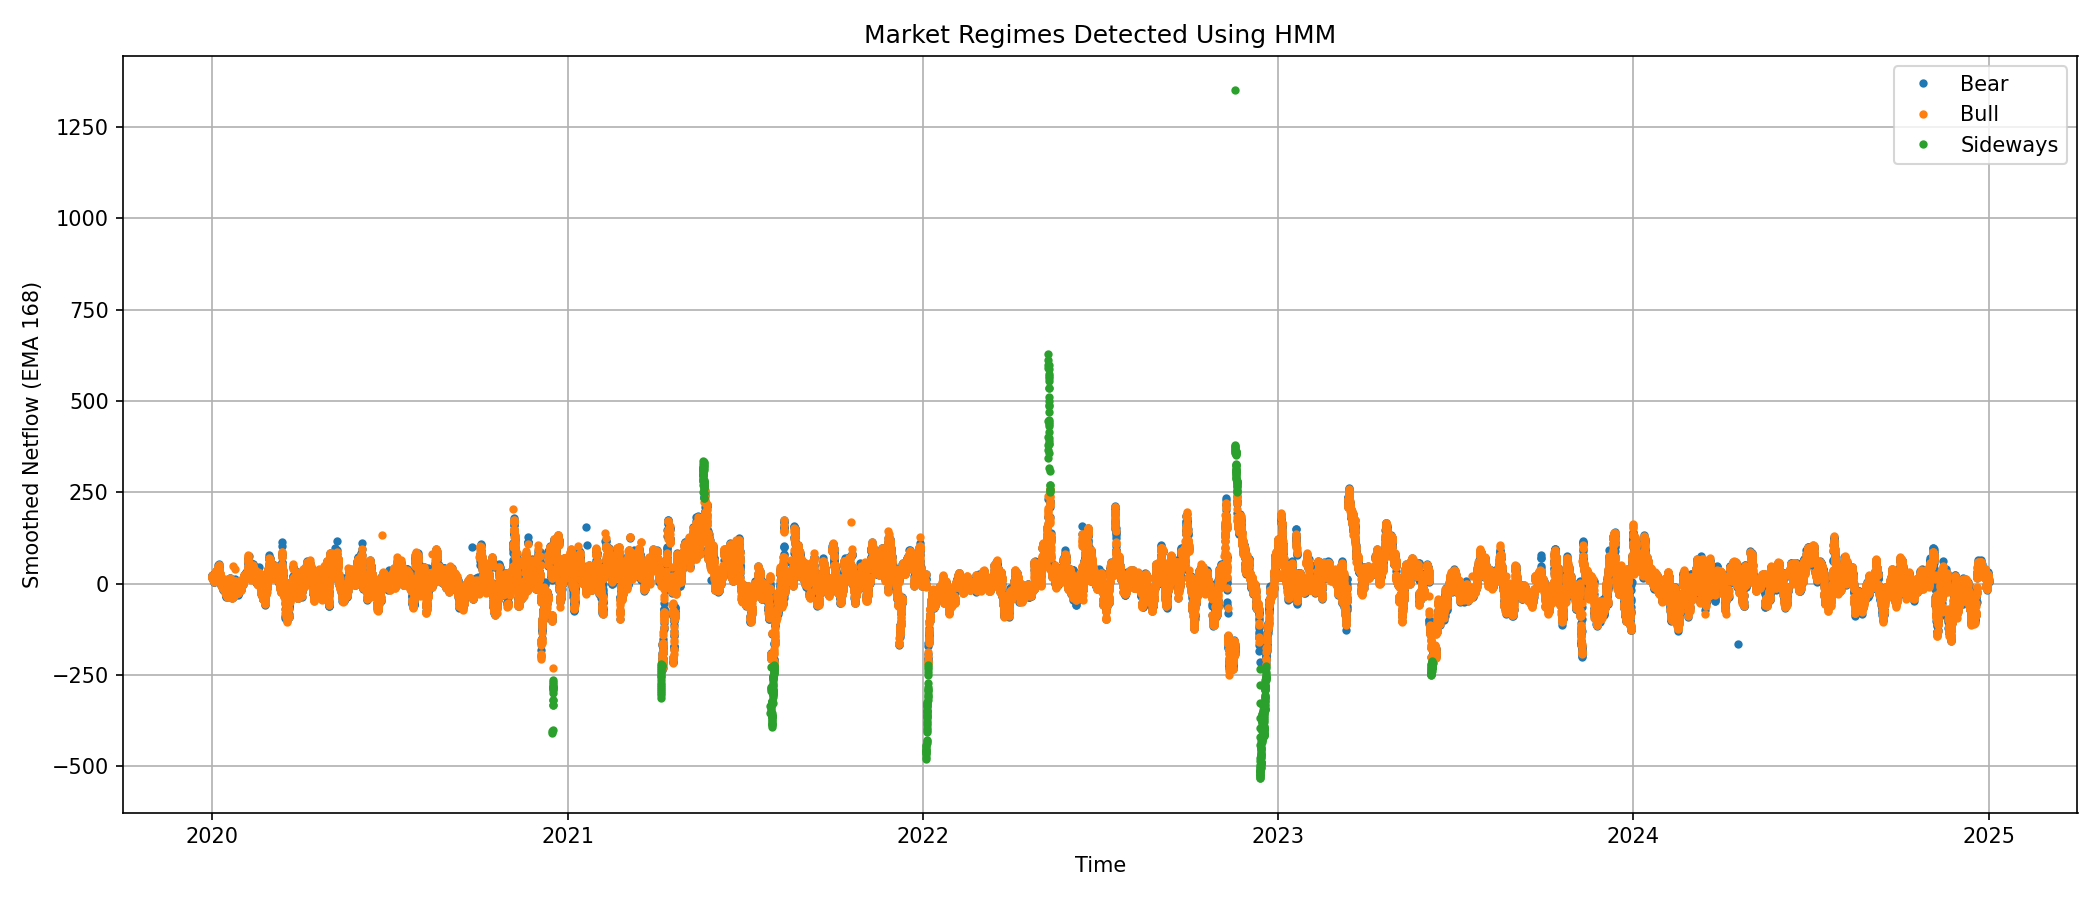

In [ ]:
# Plot and save to file
plt.figure(figsize=(14, 6))
for label in hmm_df['regime_label'].unique():
    subset = hmm_df[hmm_df['regime_label'] == label]
    plt.plot(subset['date_time'], subset['ema_168'], '.', label=label)

plt.legend()
plt.title("Market Regimes Detected Using HMM")
plt.xlabel("Time")
plt.ylabel("Smoothed Netflow (EMA 168)")
plt.grid(True)
plt.tight_layout()

# Save the plot to a file
plt.savefig("hmm_regime_plot.png", dpi=150)

# Display in notebook
Image("hmm_regime_plot.png")


In [ ]:
regime_summary = hmm_df.groupby('regime').agg({
    'price_direction': 'mean',  # Proportion of time price went up
    'ema_168': 'mean'           # Average netflow
}).rename(columns={'price_direction': 'avg_price_up_ratio', 'ema_168': 'avg_netflow'})

print(regime_summary)

        avg_price_up_ratio  avg_netflow
regime                                 
0                 0.000000     9.619168
1                 1.000000     9.076269
2                 0.511579  -155.193641


In [ ]:
log_likelihood = model.score(scaled_features)
print(f"Log Likelihood: {log_likelihood}")


Log Likelihood: 191027.14167560686


In [ ]:
def compute_aic_bic(model, X):
    n_params = model.n_components**2 + model.n_components * X.shape[1] * 2  # transmat + means + covars
    log_likelihood = model.score(X)
    aic = 2 * n_params - 2 * log_likelihood
    bic = np.log(X.shape[0]) * n_params - 2 * log_likelihood
    return aic, bic

aic, bic = compute_aic_bic(model, scaled_features)
print(f"AIC: {aic:.2f}, BIC: {bic:.2f}")

AIC: -382012.28, BIC: -381829.84


In [ ]:
!pip install backtrader
import backtrader as bt

In [ ]:
bt_df = df[['date_time', 'open', 'high', 'low', 'close', 'volume']].copy()
bt_df = pd.merge(bt_df, hmm_df[['date_time', 'regime']], on='date_time', how='inner')

# Format for Backtrader: set datetime index
bt_df['datetime'] = pd.to_datetime(bt_df['date_time'])
bt_df.set_index('datetime', inplace=True)
bt_df = bt_df[['open', 'high', 'low', 'close', 'volume', 'regime']].dropna()

In [ ]:
class PandasDataRegime(bt.feeds.PandasData):
    lines = ('regime',)  # Add regime as a new line
    params = (('regime', -1),)  # Column index -1 means "auto-detect"

In [ ]:
class RegimeStrategy(bt.Strategy):
    def __init__(self):
        self.regime = self.datas[0].regime
        self.order = None

    def next(self):
        if self.position:  # Already in the market
            if self.regime[0] != 0:  # Exit if no longer in Bull regime
                self.close()
        else:
            if self.regime[0] == 0:  # Bull regime: enter position
                self.buy()


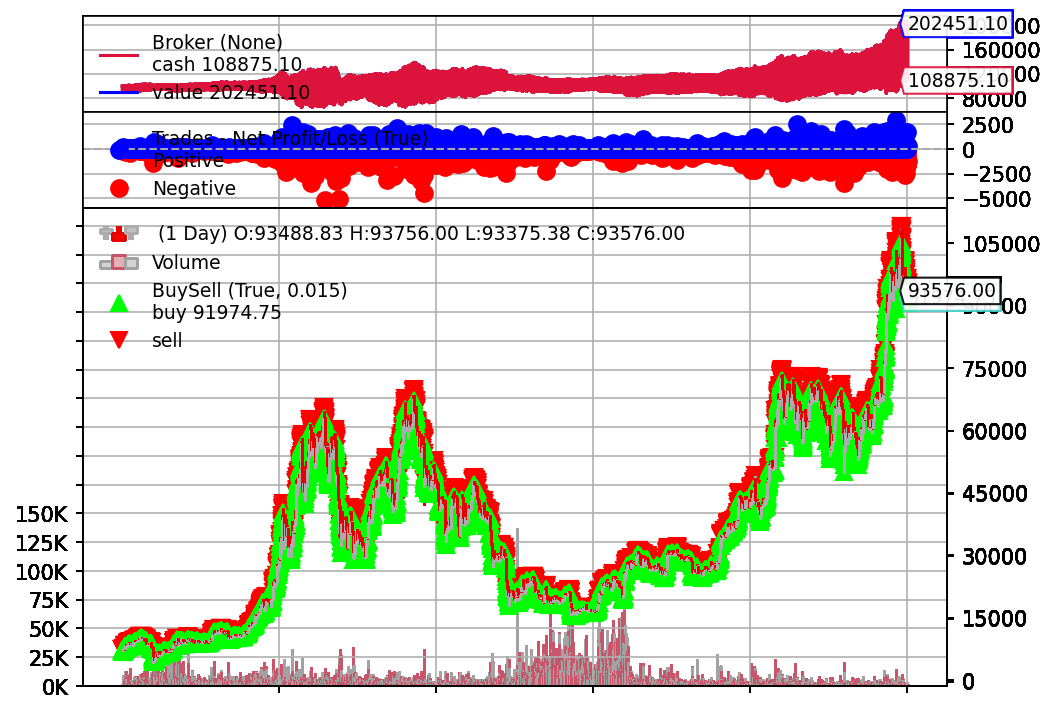

In [ ]:
cerebro = bt.Cerebro()
cerebro.addstrategy(RegimeStrategy)

# Add the custom data feed
data = PandasDataRegime(dataname=bt_df)
cerebro.adddata(data)

# Set initial capital
cerebro.broker.setcash(100000.0)


# Run the backtest
cerebro.run()

# Save the plot to a file
fig = cerebro.plot(iplot=False, style='candlestick', figsize=(20,10))[0][0]
fig.savefig("backtest_output.png", dpi=150, bbox_inches='tight')

# Display in notebook
from IPython.display import Image
Image("backtest_output.png")

In [ ]:
cerebro = bt.Cerebro()
cerebro.addstrategy(RegimeStrategy)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.adddata(PandasDataRegime(dataname=bt_df))
cerebro.broker.setcash(100000.0)

results = cerebro.run()
strategy = results[0]

# Get drawdown report
dd = strategy.analyzers.drawdown.get_analysis()

print(f"🔻 Max Drawdown %: {dd.max.drawdown:.2f}%")
print(f"💸 Max Drawdown Money: {dd.max.moneydown:.2f}")
print(f"⏳ Drawdown Length: {dd.len} bars")

🔻 Max Drawdown %: 21.92%
💸 Max Drawdown Money: 30458.46
⏳ Drawdown Length: 338 bars


In [ ]:
cerebro = bt.Cerebro()
cerebro.addstrategy(RegimeStrategy)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Minutes, compression=60)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

# Add data, set capital
cerebro.adddata(PandasDataRegime(dataname=bt_df))
cerebro.broker.setcash(100000)

# Run strategy
results = cerebro.run()
strategy = results[0]

# Output sharpe ratio
sharpe = strategy.analyzers.sharpe.get_analysis()
if sharpe and 'sharperatio' in sharpe:
    print(f"📈 Sharpe Ratio: {sharpe['sharperatio']:.2f}")
else:
    print("⚠️ Sharpe Ratio could not be calculated.")


📈 Sharpe Ratio: -6.74


In [ ]:
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Final Portfolio Value: 202451.10


<IPython.core.display.Javascript object>

<ipython-input-133-40f546faad48>:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-133-40f546faad48>:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('equity_curve.png', dpi=150)


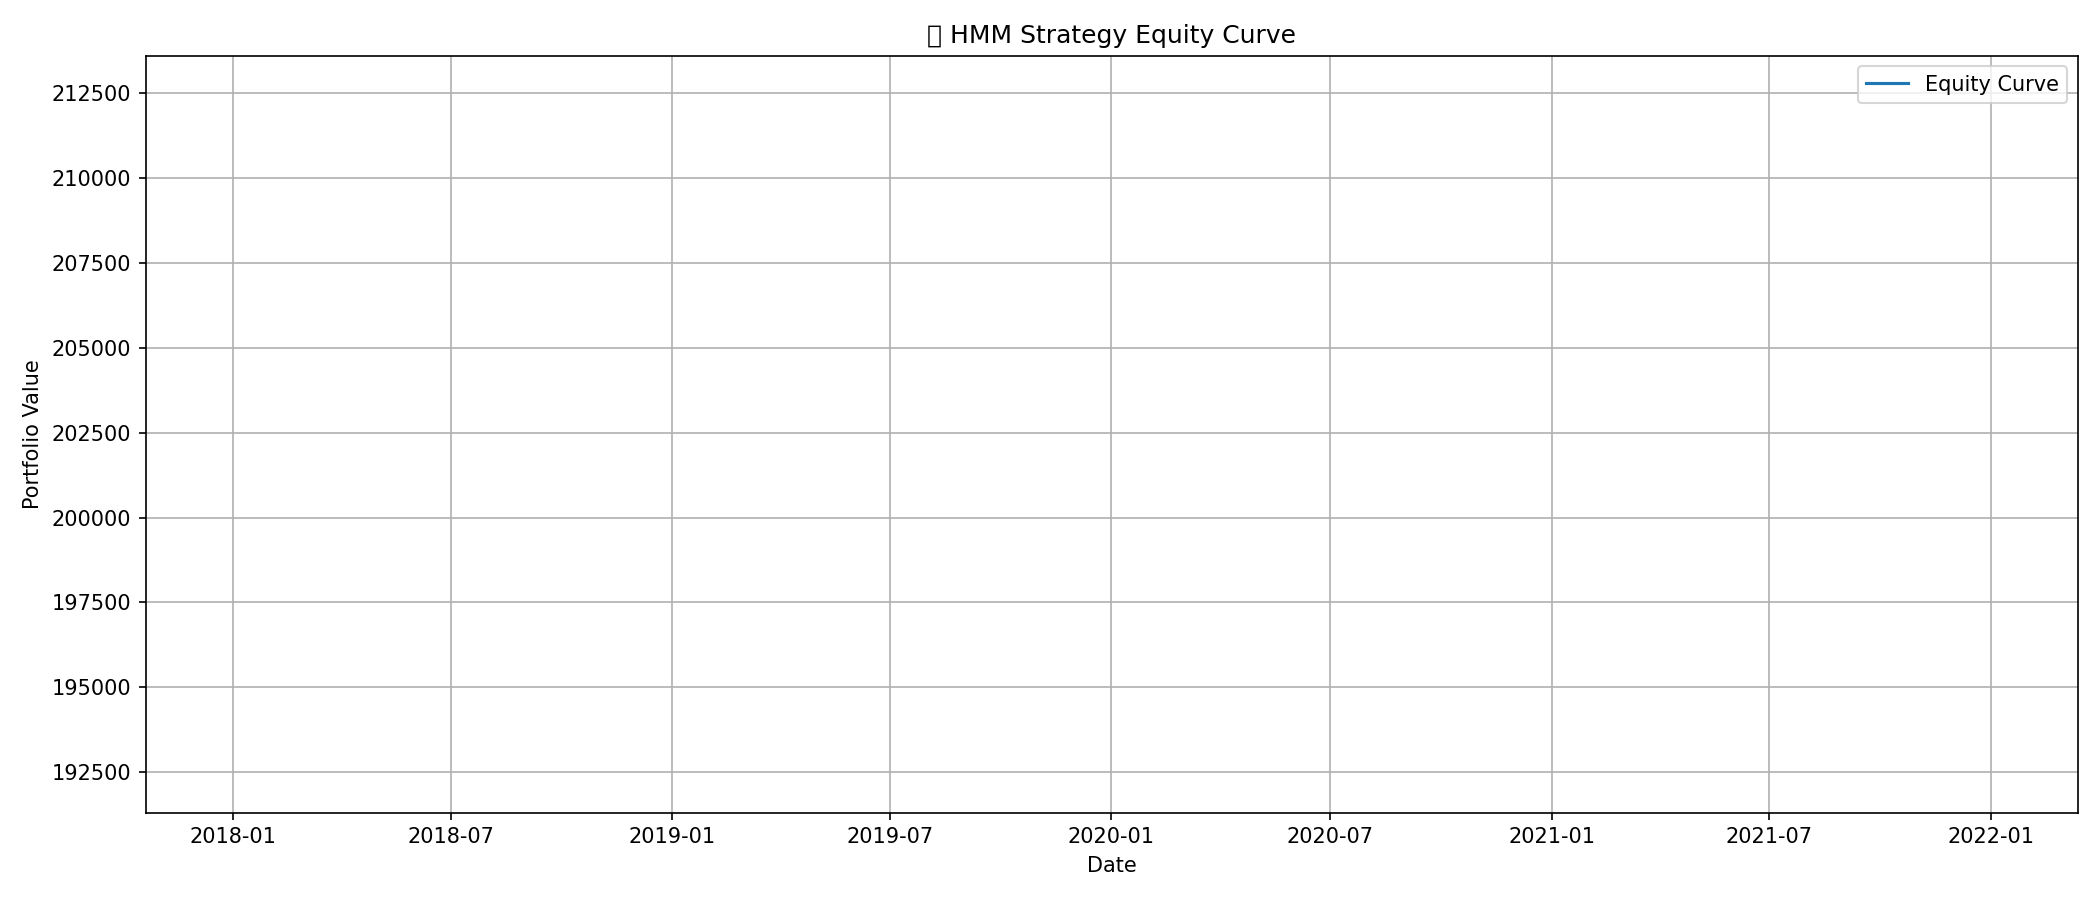

In [ ]:
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='returns', timeframe=bt.TimeFrame.NoTimeFrame)
results = cerebro.run()
strategy = results[0]

# Get equity returns per bar
returns = pd.Series(strategy.analyzers.returns.get_analysis())

# Convert to equity (cumulative return)
equity_curve = (returns + 1).cumprod() * cerebro.broker.startingcash

# Create a datetime index from the original data
equity_curve.index = bt_df.index[:len(equity_curve)]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(equity_curve, label='Equity Curve')
plt.title('📈 HMM Strategy Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save to file
plt.savefig('equity_curve.png', dpi=150)

# Show inside notebook
from IPython.display import Image
Image(filename='equity_curve.png')


In [ ]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
results = cerebro.run()
strategy = results[0]
trade_analysis = strategy.analyzers.trades.get_analysis()
total_trades = trade_analysis.total.closed
print(f"🔄 Total Closed Trades: {total_trades}")

# Count total bars per regime
regime_counts = hmm_df['regime'].value_counts().sort_index()

# Assume you're only trading in regime 0 (Bull)
# Create a 'trade_flag' series: 1 where you traded, else 0
# This must be aligned with hmm_df and your Backtrader logic!

hmm_df['trade_flag'] = 0
hmm_df.loc[hmm_df['regime'] == 0, 'trade_flag'] = 1

# Count trades per regime
trade_frequency = hmm_df.groupby('regime')['trade_flag'].sum()

# Compute trade rate as % of regime bars
trade_freq_matrix = pd.DataFrame({
    'bars_in_regime': regime_counts,
    'trades_in_regime': trade_frequency
})
trade_freq_matrix['trade_rate (%)'] = (trade_freq_matrix['trades_in_regime'] / trade_freq_matrix['bars_in_regime']) * 100

trade_freq_matrix


🔄 Total Closed Trades: 11590


,bars_in_regime,trades_in_regime,trade_rate (%)
regime,,,
0,21279,21279,100.0
1,22062,0,0.0
2,475,0,0.0


<IPython.core.display.Javascript object>

<ipython-input-140-f922008020b0>:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-140-f922008020b0>:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("trade_frequency_heatmap.png", dpi=150)


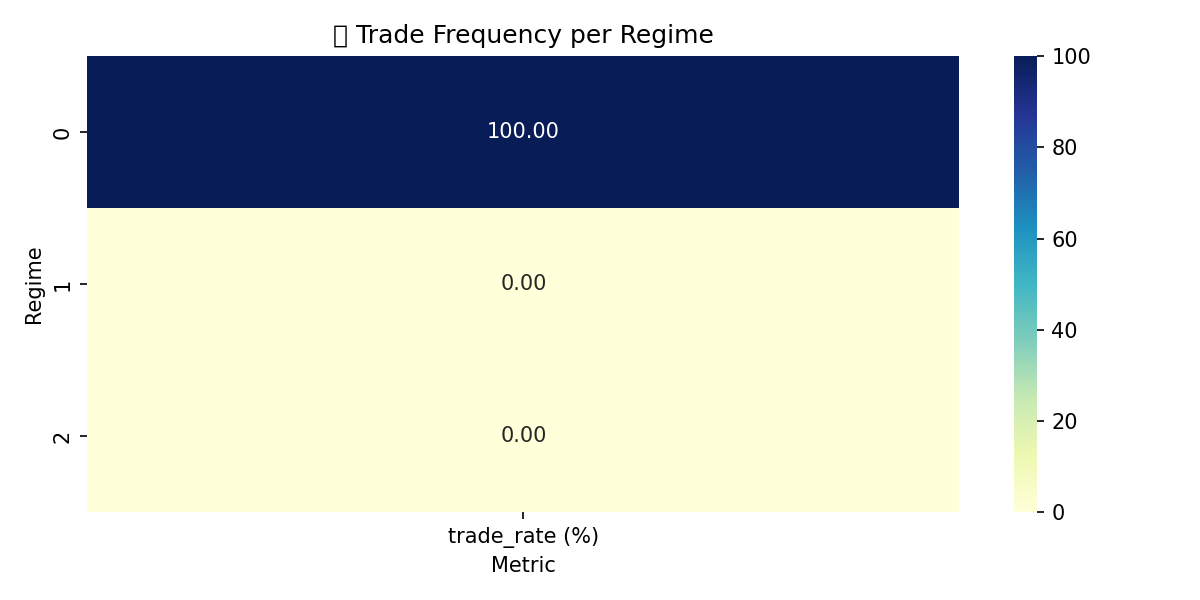

In [ ]:
!pip install seaborn
import seaborn as sns

plt.figure(figsize=(8, 4))  # Increase figure size if needed

sns.heatmap(
    trade_freq_matrix[['trade_rate (%)']],
    annot=True,
    cmap="YlGnBu",
    fmt=".2f"
)

plt.title("📊 Trade Frequency per Regime")
plt.xlabel("Metric")
plt.ylabel("Regime")
plt.tight_layout()
plt.savefig("trade_frequency_heatmap.png", dpi=150)

# Show in notebook (Colab-safe)
from IPython.display import Image
Image("trade_frequency_heatmap.png")

